# Investigating the effects of neighboring counties on hospital reporting

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import pickle
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import *
from src.utils.dates import get_today, lag_date, date2str, str2date, get_format
from src.utils.df_utils import get_date_columns
from src.pandas.align import align_lagged_dates

from scipy.stats import spearmanr

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Time series data
mobility, mobility_date = load_google_mobility()
deaths, deaths_date = load_deaths(join_county_codes=False)
interventions, interventions_date = load_interventions()

# Static data
counties, counties_date = load_counties()

# Processed mobility -> time series
mobility_ts, mobility_ts_date = load_google_mobility_time_series()

m50,_ = load_descartes_m50()

od_mobility = load_od_baseline()

hospitals = load_acute_care(beds=True)

print(f'Mobility Last Updated {mobility_ts_date}')
print(f'Deaths Last Updated {deaths_date}')

# County adjacency edge list
with open('../data/processed/county_adjacency_edge_dict.pkl', 'rb') as f:
    county_adj = pickle.load(f)

Mobility Last Updated 05-08
Deaths Last Updated 05-26


## Urban counties with outbreaks >= N days
For each county with RUCC 1 and at least N days of outbreak, we examine its ratio of hospitals to population normlized cumulative deaths over those N days compared to neighboring counties

In [4]:
N_DAYS = 14

In [5]:
# Get death dataframe date columns
death_dates = get_date_columns(mobility_ts, return_dtimes=False)

In [131]:
total_deaths = deaths[['FIPS'] + death_dates]
total_deaths['avg_deaths'] = total_deaths.apply(lambda x: sum(x[death_dates]) / max(sum(x[death_dates] > 0), 1), axis=1)
total_deaths = total_deaths.dropna(axis=0, subset=['FIPS'])
total_deaths['FIPS'] = total_deaths['FIPS'].astype(int)
total_deaths = total_deaths.drop(columns=death_dates)

In [132]:
total_deaths = pd.merge(total_deaths, counties[['FIPS','Total Hospitals (2019)', 'ICU Beds', 'POP_ESTIMATE_2018']], on='FIPS')

In [133]:
def normalize(row, cols, target='cum_deaths'):
    """
    Normalizes target column by column cols
    norm_type : list of len(cols)
     - 1 to multiply target by (i.e. density)
     - -1 to divide target by (i.e. total pop)
    """
    r = row[target]
    for col,norm_type in cols.items():
        if pd.isnull(row[col]):
            row[col] = np.nan
        break
        r *= int(row[col])**(norm_type)

    return r

In [134]:
total_deaths['normalized_deaths'] = total_deaths.apply(lambda r: r['avg_deaths'] / r['POP_ESTIMATE_2018'], axis=1)

In [135]:
total_deaths.head(3)

,FIPS,avg_deaths,Total Hospitals (2019),ICU Beds,POP_ESTIMATE_2018,normalized_deaths
0,1001,1.884615,1.148905,6.0,55601,0.000034
1,1003,1.971429,4.505074,51.0,218022,0.000009
2,1005,1.000000,0.514126,5.0,24881,0.000040


### Only with outbreaks

In [136]:
def get_onset_date(row, thresh = 5):
    above = row[row > thresh]
    if len(above) == 0:
        return np.nan
    else:
        return above.idxmin()

def append_cumulative_deaths(df, time_cols, time_length):
    df['cum_deaths'] = df.apply(
        lambda r: sum(r[[d for d in time_cols if 
            str2date(d) >= str2date(r['onset']) and 
            str2date(d) < lag_date(str2date(r['onset']), lag=time_length, backwards=False)
            ]]
    ), axis=1)

    return df

In [137]:
## Normalize deaths by population total
deaths_df = deaths[['FIPS']+death_dates]

deaths_df['onset'] = deaths_df[death_dates].apply(lambda row: get_onset_date(row), axis=1)

## New date range of outbreak >= N_DAYS
deaths_df = deaths_df.dropna(axis=0, subset=['onset'])

deaths_df = deaths_df[deaths_df['onset'].apply(
    lambda d: (str2date(death_dates[-1]) - str2date(d)).days >= N_DAYS
    )]

## Get cumulative deaths over that range
deaths_df = append_cumulative_deaths(deaths_df, death_dates, N_DAYS)

In [138]:
## Just cumulative deaths
cum_deaths = deaths_df[['FIPS', 'cum_deaths']]
cum_deaths = cum_deaths.dropna(axis=0, subset=['FIPS'])
cum_deaths = cum_deaths.astype({'FIPS':int})
cum_deaths = pd.merge(cum_deaths, counties[['FIPS','Total Hospitals (2019)', 'ICU Beds']], on='FIPS')

In [139]:
confounders = [
    'POP_ESTIMATE_2018',
    'Density per square mile of land area - Population',
    'Rural-urban_Continuum Code_2013',
    'Total_age65plus',
]
cum_deaths = pd.merge(cum_deaths, counties[['FIPS'] + confounders], on='FIPS')

In [140]:
def normalize(row, cols, target='cum_deaths'):
    """
    Normalizes target column by column cols
    norm_type : list of len(cols)
     - 1 to multiply target by (i.e. density)
     - -1 to divide target by (i.e. total pop)
    """
    r = row[target]
    for col,norm_type in cols.items():
        if pd.isnull(row[col]):
            row[col] = np.nan
        break
        r *= int(row[col])**(norm_type)

    return r

In [179]:
cum_deaths['normalized_deaths'] = cum_deaths.apply(
    lambda row: normalize(row, {
            'POP_ESTIMATE_2018' : -1,
            'Density per square mile of land area - Population': 0,
            'Rural-urban_Continuum Code_2013': 0,
            'Total_age65plus': 0,
            'Total Hospitals (2019)': -1,
        }), axis=1
    )
cum_deaths['percent_age65plus'] = cum_deaths.apply(lambda row: row['Total_age65plus'] / row['POP_ESTIMATE_2018'], axis=1)

In [146]:
urban_outbreaks = cum_deaths[cum_deaths['Rural-urban_Continuum Code_2013'] == 1.0]['FIPS']

In [147]:
adj_outbreaks = []
for fip in urban_outbreaks:
    if fip not in county_adj.keys():
        print(f'Count {fip} not present')
        continue
    adj_fips = []
    for adj_fip in county_adj[fip]:
        if adj_fip in urban_outbreaks:
            continue
        try:
            adj_fips.append(adj_fip)
        except:
            pass
    adj_outbreaks.append((fip, adj_fips))

Text(0.5, 1.0, 'Number of RUCC > 1 outbreaks neghboring RUCC 1 outbreaks')

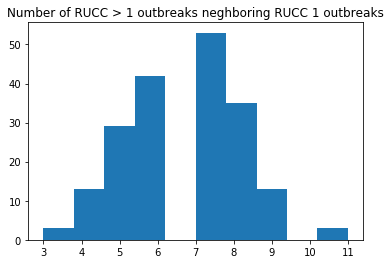

In [148]:
plt.hist([len(a[1]) for a in adj_outbreaks])
plt.title('Number of RUCC > 1 outbreaks neghboring RUCC 1 outbreaks')

### Compare center to neighbors
We consider the cumulative deaths after outbreak for N_DAYS per the county population. We call the ratio of this to the number of hospitals $d_H$.

We have a center $x_0$ and neighbors $x_1,...,x_n$ with mean $\mu_x$ and standard deviation $\sigma_x$. The difference is $d_H - \mu_x$.


In [180]:
x = []
y = []
stds = []
for center_fip, adj_fips in adj_outbreaks:
    x.append(cum_deaths[cum_deaths['FIPS'] == center_fip]['Total Hospitals (2019)'].iloc[0])
    center_deaths = cum_deaths[cum_deaths['FIPS'] == center_fip]['normalized_deaths'].iloc[0]
    adj_deaths = cum_deaths[cum_deaths['FIPS'].isin(adj_fips)]['normalized_deaths']
    y.append(center_deaths - adj_deaths.mean())
    if len(adj_deaths) == 0:
        stds.append(0)
    else:
        stds.append(adj_deaths.std())

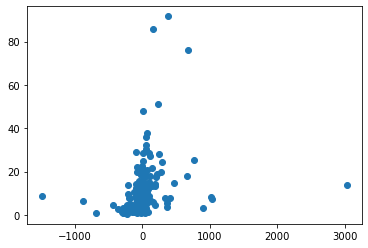

In [185]:
plt.scatter(y,x)